In [43]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

from tqdm import tqdm
import random

In [45]:
# dataloader arguments
batch_size = 128
data_path='./Data'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnistTrain = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnistTest = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Split the training dataset into validation and training (80/20 ratio)
trainSize, testSize = .8, .2,# Percentage
trainSize = int(trainSize*len(mnistTrain)) # Number of samples
validationSize = len(mnistTrain) - trainSize
mnistTrain, mnistVal = random_split(mnistTrain, [trainSize, validationSize])

# Create DataLoaders
trainLoader = DataLoader(mnistTrain, batch_size=batch_size, shuffle=True, drop_last=True)
validationLoader = DataLoader(mnistVal, batch_size=batch_size, shuffle=True, drop_last=True)
testLoader = DataLoader(mnistTest, batch_size=batch_size, shuffle=True, drop_last=True)

In [46]:
# Network architecture
inputSize = 28 * 28 # Each MNIST dataset image has a 28 x 28 image size
hiddenSize = 1000
outSize = 10 # 10 Digits
numSteps = 25
beta = .95


loss = nn.CrossEntropyLoss()

# Define the network
class ExampleSNN(nn.Module):
    """
    Our very first implementation of a spiking neural network
    """
    def __init__(self, *args, **kwargs):
        # Inherit necessary variables from nn.Module
        super().__init__()
        
        # Make the layers
        self.layer1 = nn.Linear(inputSize, hiddenSize)
        self.LIF1 = snn.Leaky(beta = beta)
        self.layer2 = nn.Linear(hiddenSize, outSize)
        self.LIF2 = snn.Leaky(beta = beta)
    
    def forward(self, x, y):
        """
        The forward pass of the network. This part is important because we impose
        spiking behavior of neurons in it.
        
        Args:
            x: each layer's output.
        """
        # Set initial potentials to be zero
        potential1 = self.LIF1.reset_mem()
        potential2 = self.LIF2.reset_mem()
        
        # Save the state of the output layer
        layer2Spikes = []
        layer2Potentials = []
        
        for step in range(numSteps):
            current1 = self.layer1(x)
            
            spk1, potential1 = self.LIF1(current1, potential1)
            current2 = self.layer2(spk1)
            spk2, potential2 = self.LIF2(current2, potential2)
            
            # Save output
            layer2Spikes.append(spk2)
            layer2Potentials.append(potential2)
        
        # Calculate the loss
        _loss = torch.zeros((1), dtype = torch.float32, device=device)
        for step in range(numSteps):
            _loss += loss(layer2Potentials[step], y)
            
        return torch.stack(layer2Spikes, dim = 0), torch.stack(layer2Potentials, dim = 0), _loss


In [5]:
net = ExampleSNN().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

# The training loop
numEpochs = 1
lstLoss = []
lstValidationLoss = []
counter = 0

for epoch in range(numEpochs):
    print(f"Epoch number {epoch+1}/{numEpochs}")
    
    trainBatch = iter(trainLoader)
    
    for data, target in tqdm(trainBatch, total = len(trainBatch)):
        
        data = data.to(device)
        target = target.to(device)
        
        # Set the model to training mode
        net.train()
        
        # Flatten each batch data and feed it to network
        _spk, _pot, _loss = net(data.reshape(batch_size, -1), target)
        
        # Update the weights
        optimizer.zero_grad() # Set previous gradients to zero
        _loss.backward()
        optimizer.step()
        
        lstLoss.append(_loss.item())
        
        # Test data
        _validationLoss = torch.zeros((1), dtype=dtype, device=device)
        with torch.no_grad():
            # Set the network in evaluation mode
            net.eval()
            
            validationData, validationTarget = next(iter(validationLoader))
            validationData = validationData.to(device)
            validationTarget = validationTarget.to(device)
            
            # Feed the test to current trained network
            _, _, _validationLoss = net(validationData.view(batch_size, -1), validationTarget)
            lstValidationLoss.append(_validationLoss.item())

Epoch number 1/1


100%|██████████| 375/375 [01:09<00:00,  5.38it/s]


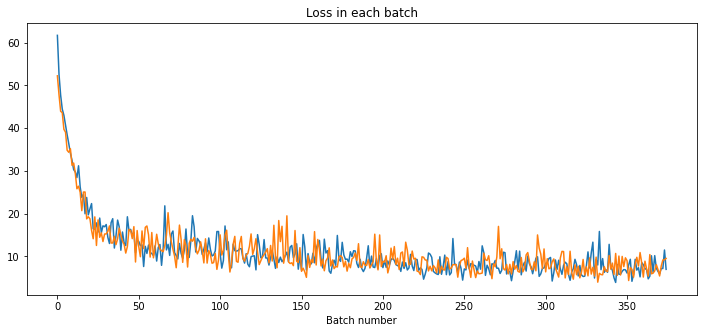

In [47]:
# Plot the loss of training and validation sets
fig = plt.figure(facecolor="w", figsize=(12, 5))
plt.title("Loss in each batch")
plt.plot(lstLoss)
plt.plot(lstValidationLoss)
plt.xlabel("Batch number")
plt.show()

In [152]:
# Get the accuracy for the test dataset
total = 0
correct = 0

with torch.no_grad():
    net.eval()
    
    for data, target in tqdm(testLoader, total = len(testLoader)):
        target = target.to(device)
        spikes, _, _ = net(data.view(batch_size,-1).to(device), target)
        
        # Get accuracy
        total += data.shape[0]
        correct += torch.sum(target.to(device) == torch.max(spikes.sum(dim =  0), dim = 1)[1]).item()

print(f"Test accuracy: {100*correct/total:.2f}%")

100%|██████████| 78/78 [00:05<00:00, 14.41it/s]

Test accuracy:93.16%


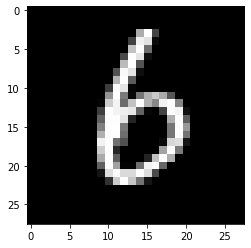

Actual target: 6 | Predicted target: 6


In [122]:
# Test and visualize the trained network
testDataset = testLoader.dataset
randomSample = testDataset[random.randint(0, len(testDataset) - 1)]
img = randomSample[0]
target = randomSample[1]

plt.imshow(img.squeeze(), cmap="gray")
plt.show()

target = torch.tensor(target, device=device).unsqueeze(0)
img = img.to(device)
net.eval()
spikes, _, _ = net(img.view(1,-1), target)

print(f"Actual target: {target.item()} | Predicted target: {spikes.sum(dim = 0).argmax(1).item()}")

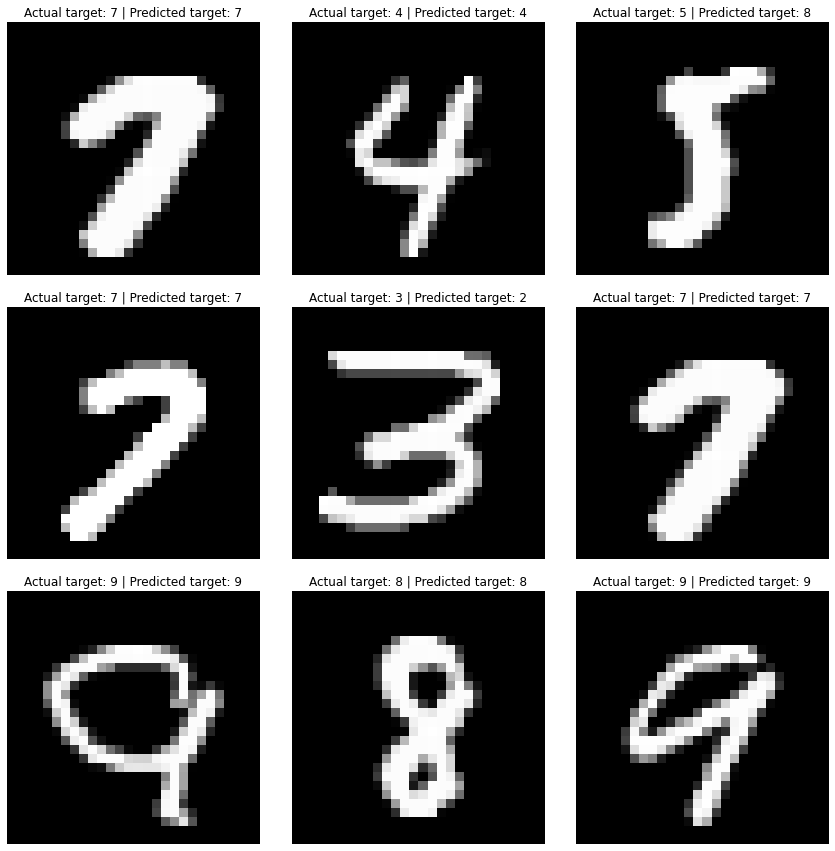

In [167]:
# Visualize the results

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Iterate and add images to subplots
for i, ax in enumerate(axes.flat):
    testDataset = testLoader.dataset
    randomSample = testDataset[random.randint(0, len(testDataset) - 1)]
    img = randomSample[0]
    target = randomSample[1]
    
    ax.imshow(img.squeeze(), cmap="gray")

    target = torch.tensor(target, device=device).unsqueeze(0)
    img = img.to(device)
    net.eval()
    spikes, _, _ = net(img.view(1,-1), target)

    
    ax.set_title(f"Actual target: {target.item()} | Predicted target: {spikes.sum(dim = 0).argmax(1).item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()